In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries

In [2]:
df = pd.read_csv("../data/AirPassengers.csv")
df.head(10)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [3]:
original_series = TimeSeries.from_dataframe(df, time_col="Month", value_cols="#Passengers")
len(original_series)

144

(True, np.int64(12))

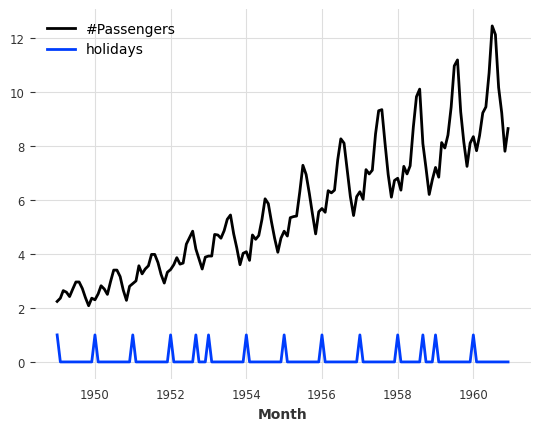

In [5]:
from darts.utils.statistics import check_seasonality

(original_series/50).add_holidays("US").plot()
check_seasonality(original_series)

In [6]:
# adjusting values dividing by the number of days in each month

adjusted_values = []
for data_point in original_series:
    days_in_month = data_point.time_index[0].days_in_month
    adjusted_values.append(data_point.values()[0][0]/days_in_month)

adjusted_series = TimeSeries.from_times_and_values(original_series.time_index, adjusted_values)

Text(0.5, 1.0, 'Adjusted series')

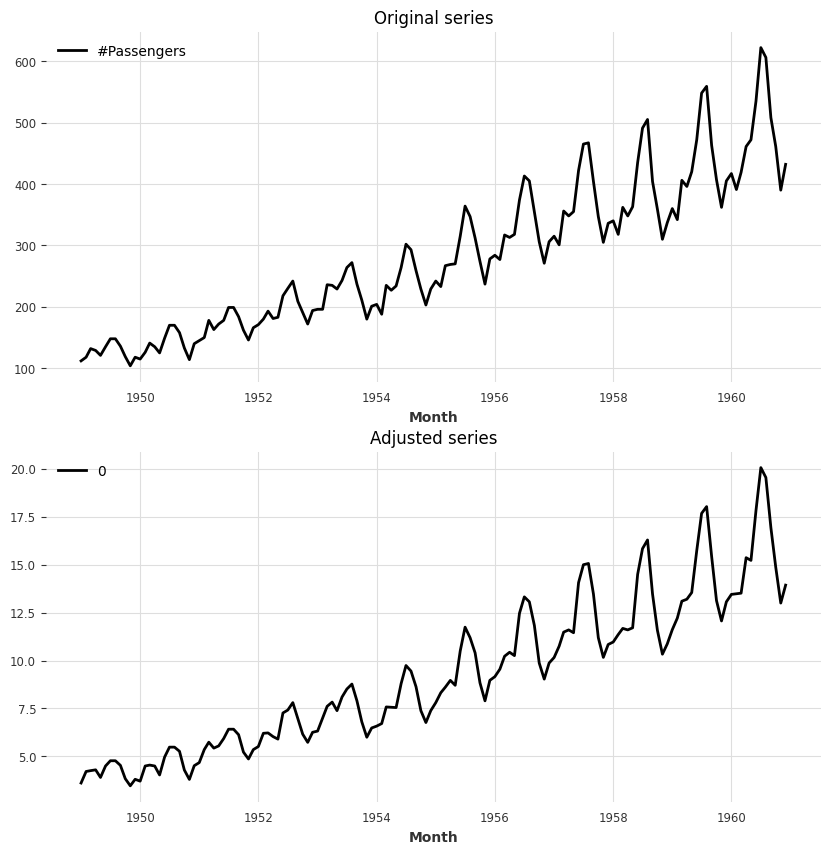

In [7]:
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
original_series.plot()
plt.title("Original series")

plt.subplot(2,1,2)
adjusted_series.plot()
plt.title("Adjusted series")


<Axes: xlabel='Month'>

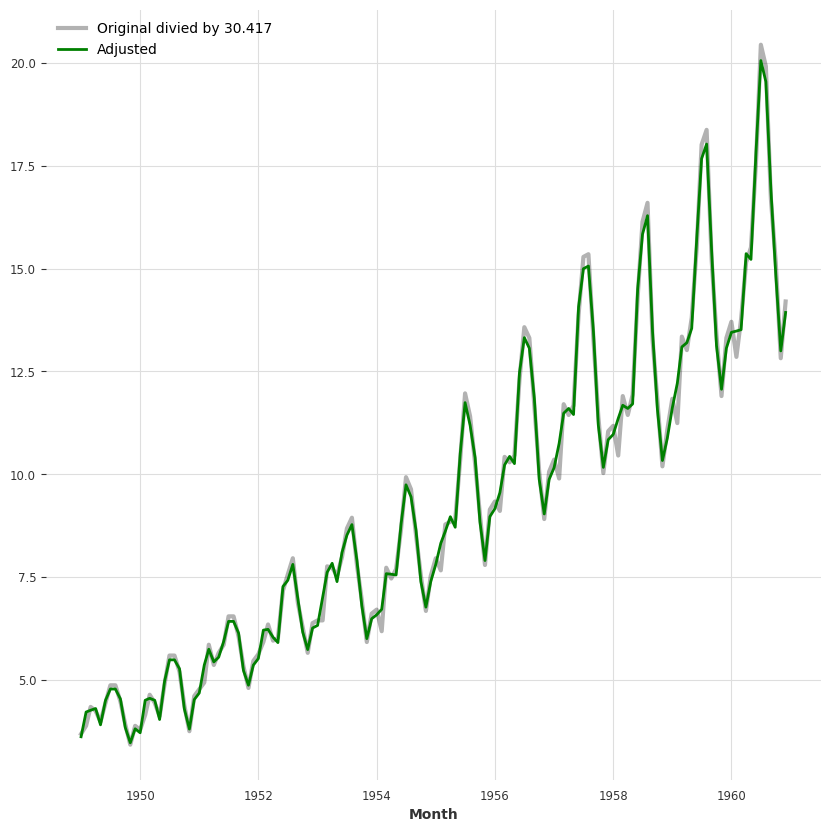

In [8]:
plt.figure(figsize=(10,10))

(original_series/30.417).plot(label="Original divied by 30.417", alpha=0.3, lw=3)

adjusted_series.plot(label="Adjusted", color="green")

In [9]:
#series = original_series
series = adjusted_series

train, val = series.split_after(0.8)

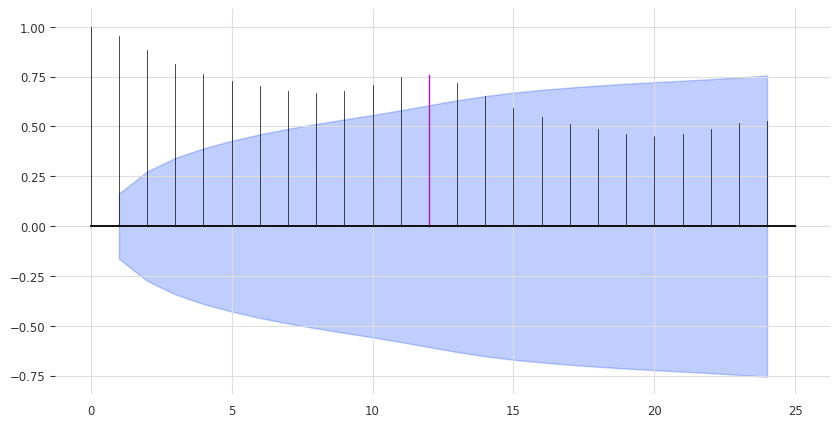

In [10]:
from darts.utils.statistics import plot_acf

plot_acf(series, m=12, max_lag=24)

In [102]:
from darts.metrics import mape

def fit_and_show_forecast(model, probabilistic=True):
    model.fit(train)
    if probabilistic:
        pred = model.predict(len(val), num_samples=500)
    else:
        pred = model.predict(len(val))
        train_pred = model.predict(len(train))
        train_pred.plot(color="yellow")

    print(f"Mean Absolute Percentage Error: {mape(val, pred):.2f}%.")
    
    series.plot(label="True")
    #pred.plot(label="Predicted: "+model.__str__())
    pred.plot(label="Predicted: "+model.__class__.__name__)
    return pred

def plot_bias_adjusted(observed, pred):
    residuals = observed - pred
    residuals_mean = sum(residuals.values())/len(residuals)
    pred_no_bias = pred + residuals_mean
    
    print(f"Mean Absolute Percentage Error: {mape(observed, pred_no_bias):.2f}%.")
    
    series.plot(label="True")
    pred_no_bias.plot(label="Bias corrected prediction", color="forestgreen")
    #plot_acf(residuals, m=5, alpha=0.05, max_lag=10)



    
# --------- some old funcions
"""
def residual_mean(model):
    residual_array = model.residuals(val).values()
    residual_array_mean = sum(residual_array)/len(residual_array)
    return residual_array_mean

def plot_bias_adjusted(model, pred):
    r_mean = residual_mean(model)
    pred_no_bias = pred + r_mean
    series.plot()
    pred_no_bias.plot()
"""


'\ndef residual_mean(model):\n    residual_array = model.residuals(val).values()\n    residual_array_mean = sum(residual_array)/len(residual_array)\n    return residual_array_mean\n\ndef plot_bias_adjusted(model, pred):\n    r_mean = residual_mean(model)\n    pred_no_bias = pred + r_mean\n    series.plot()\n    pred_no_bias.plot()\n'

Mean Absolute Percentage Error: 18.56%.


<Axes: xlabel='Month'>

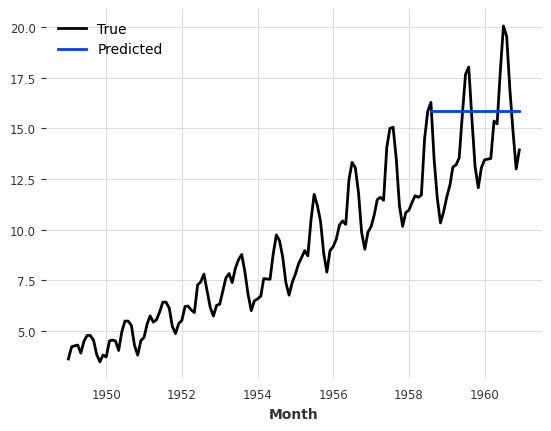

In [53]:
time_indices = val.time_index
#naive_values = np.full(len(time_indices), train.values()[-1])
naive_values = [train.values()[-1]]*len(time_indices)
pred_naive = TimeSeries.from_times_and_values(time_indices, naive_values)

print(f"Mean Absolute Percentage Error: {mape(val, pred_naive):.2f}%.")
series.plot(label="True")
pred_naive.plot(label="Predicted")

Mean Absolute Percentage Error: 43.84%.


<Axes: xlabel='Month'>

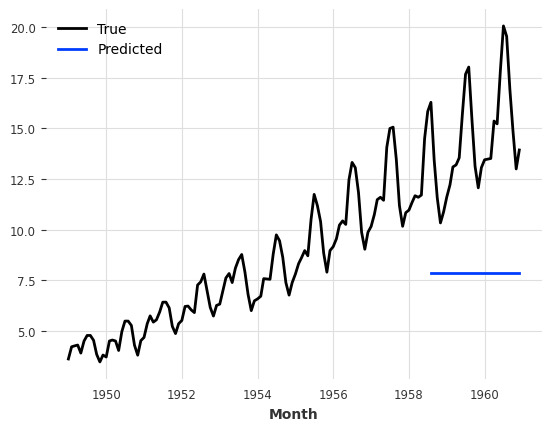

In [54]:
train_values = train.values()
mean_value = sum(train_values)/len(train_values)
time_indices = val.time_index
mean_values = np.full(len(time_indices), mean_value)
mean_series = TimeSeries.from_times_and_values(time_indices, mean_values)

print(f"Mean Absolute Percentage Error: {mape(val, mean_series):.2f}%.")
series.plot(label="True")
mean_series.plot(label="Predicted")

Mean Absolute Percentage Error: 13.94%.


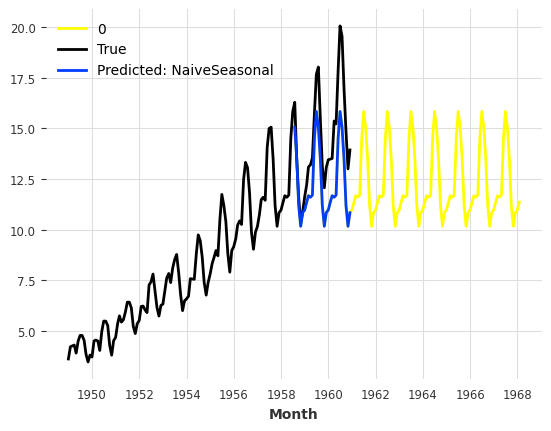

In [103]:
from darts.models import NaiveSeasonal

model_naive_seasonal = NaiveSeasonal(K=12)
pred_naive_seasonal = fit_and_show_forecast(model_naive_seasonal, probabilistic=False)

Mean Absolute Percentage Error: 7.25%.


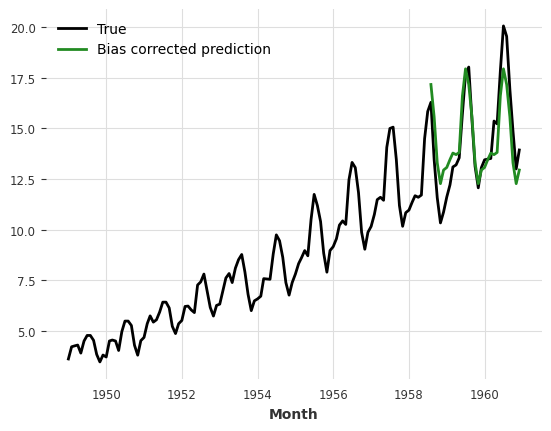

In [56]:
plot_bias_adjusted(val, pred_naive_seasonal)

Mean Absolute Percentage Error: 25.38%.


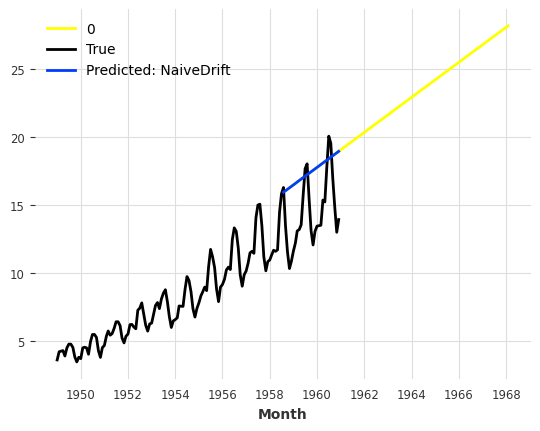

In [104]:
from darts.models import NaiveDrift

model_drift = NaiveDrift()
pred_drift = fit_and_show_forecast(model_drift, probabilistic=False)

Mean Absolute Percentage Error: 12.75%.


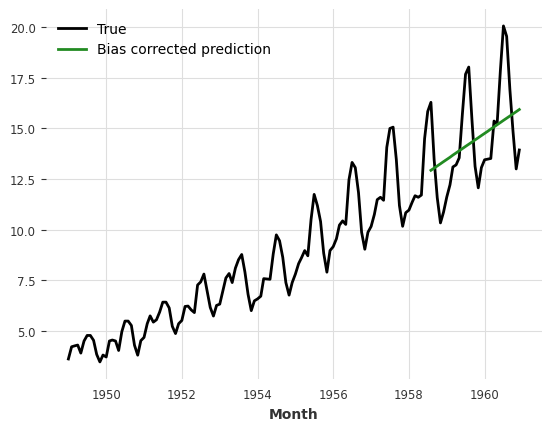

In [58]:
plot_bias_adjusted(val, pred_drift)

Mean Absolute Percentage Error: 4.30%.


<Axes: xlabel='Month'>

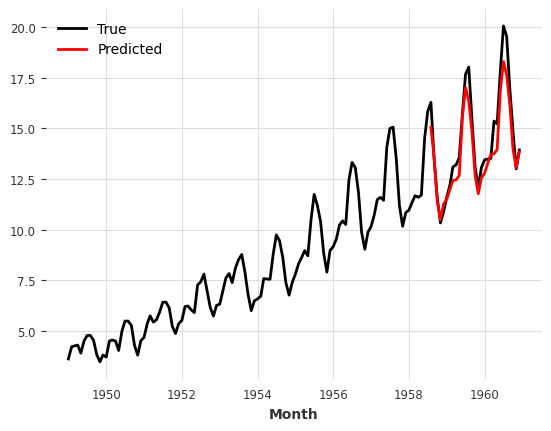

In [59]:
pred_combined = pred_naive_seasonal + (pred_drift-pred_drift[0])
print(f"Mean Absolute Percentage Error: {mape(series, pred_combined):.2f}%.")
series.plot(label="True")
pred_combined.plot(label="Predicted", color="red")

Mean Absolute Percentage Error: 3.48%.


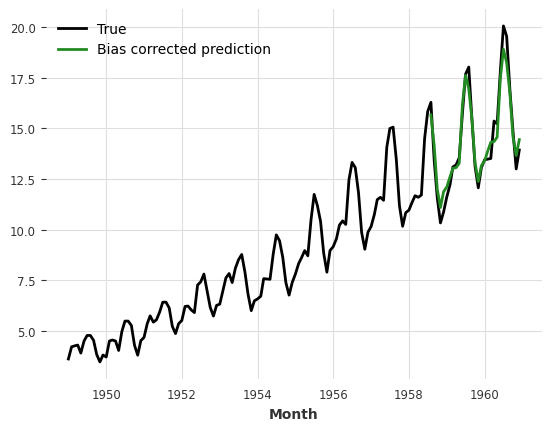

In [60]:
plot_bias_adjusted(val, pred_combined)

Mean Absolute Percentage Error: 11.36%.


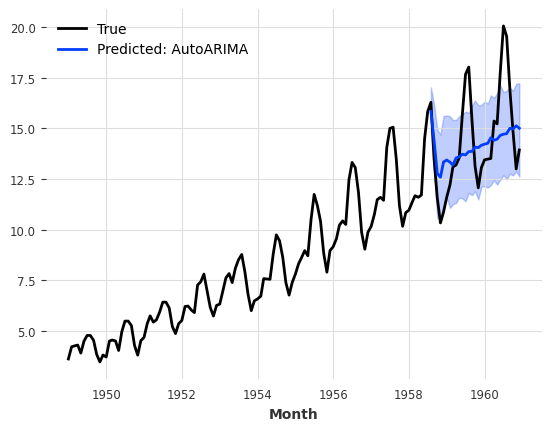

In [61]:
from darts.models import AutoARIMA

model_aarima = AutoARIMA()
pred_aarima = fit_and_show_forecast(model_aarima)

Mean Absolute Percentage Error: 6.53%.


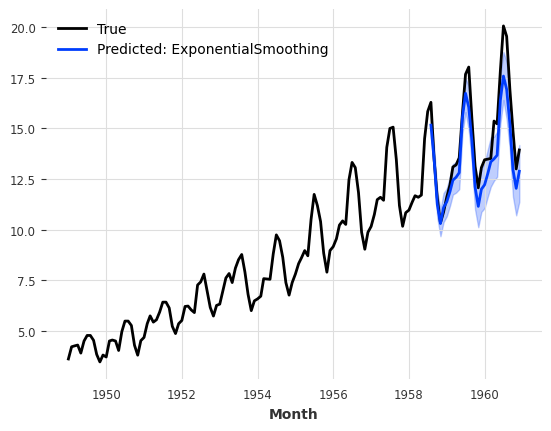

In [62]:
from darts.models import ExponentialSmoothing

model_ES = ExponentialSmoothing()
pred_ES = fit_and_show_forecast(model_ES)

In [100]:
models = [ExponentialSmoothing(), NaiveSeasonal(K=12)]
#models = [NaiveDrift()]
backtests = [model.historical_forecasts(series,
                            start=.5,
                            forecast_horizon=3)
             for model in models]

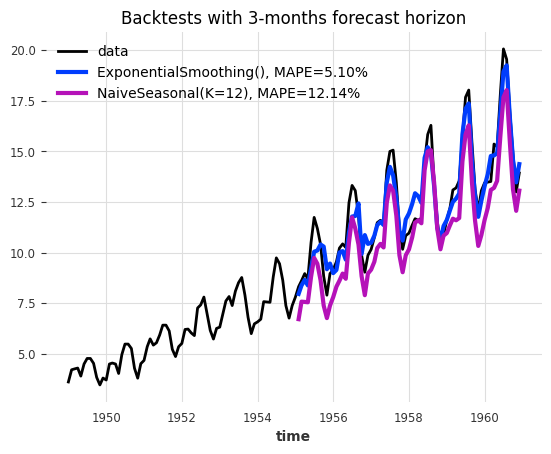

In [101]:
from darts.metrics import mape
series.plot(label='data')
for i, m in enumerate(models):
    err = mape(backtests[i], series)
    backtests[i].plot(lw=3, label='{}, MAPE={:.2f}%'.format(m, err))
plt.title('Backtests with 3-months forecast horizon')
plt.legend()

`start` position `0` corresponding to time `1949-01-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Using the first historical forecasting point `1949-04-01 00:00:00` that lies a round-multiple of `stride=1` ahead of `start`. To hide these warnings, set `show_warnings=False`.


AttributeError: 'NaiveDrift' object has no attribute 'fitted_values'

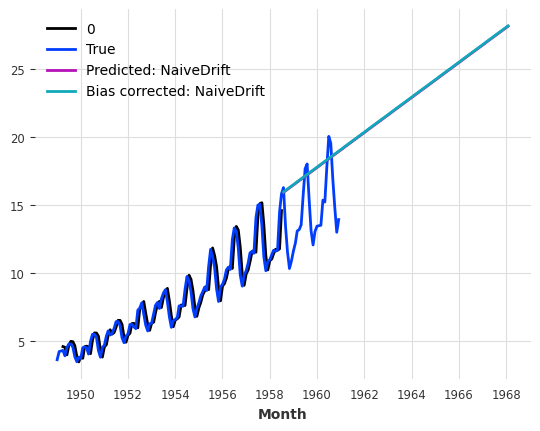

In [133]:
model = NaiveDrift()
model.fit(train)
residuals = model.residuals(train).values()
residuals_mean = sum(residuals)/len(residuals)
pred = model.predict(len(train))


historical_predictions = model.historical_forecasts(
    train,
    start=0,
    forecast_horizon=1
)

historical_predictions.plot()

series.plot(label="True")
#pred.plot(label="Predicted: "+model.__str__())
(pred).plot(label="Predicted: "+model.__class__.__name__)
(pred+residuals_mean).plot(label="Bias corrected: "+model.__class__.__name__)

residuals_mean
model.fitted_values

In [121]:
model.residuals(train).values()

array([[-0.28064516],
       [-0.62580645],
       [ 0.52419355],
       [ 0.09677419],
       [-0.19354839],
       [-0.40675883],
       [-0.80967742],
       [-0.39713262],
       [ 0.3544086 ],
       [-0.1143695 ],
       [ 0.78225806],
       [-0.01985112],
       [-0.11520737],
       [-0.52688172],
       [ 0.90819892],
       [ 0.43757116],
       [-0.10394265],
       [-0.31567629],
       [-1.05903226],
       [-0.52258065],
       [ 0.70762463],
       [ 0.12201964],
       [ 0.63536866],
       [ 0.31502304],
       [-0.39048801],
       [ 0.04763043],
       [ 0.31582181],
       [ 0.40600667],
       [-0.09354839],
       [-0.3765522 ],
       [-0.98629032],
       [-0.40801564],
       [ 0.45129665],
       [ 0.11152074],
       [ 0.63790014],
       [-0.05119803],
       [-0.26123373],
       [-0.19216984],
       [ 1.3061828 ],
       [ 0.06357199],
       [ 0.29646697],
       [-0.93730933],
       [-0.88159824],
       [-0.48458781],
       [ 0.47863488],
       [ 0